<a href="https://colab.research.google.com/github/Surendra58/AI/blob/master/MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-Agnostic Meta-Learning (MAML)

In [ ]:
# Hands-on Workshop on Optimization-based Meta Learning (AGI)

## Setup

In [ ]:
!git clone https://github.com/theneuralbeing/maml

Cloning into 'maml'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 53 (delta 29), reused 53 (delta 29), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
cd maml

/content/maml


In [ ]:
# Download
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
# Unzip to omniglot/ folder
!mkdir omniglot
!unzip images_background.zip -d omniglot/
!unzip images_evaluation.zip -d omniglot/

## Train

In [ ]:
%%time
!python train.py --gpu

Loading Data
100% 30/30 [00:02<00:00, 14.38it/s]
Epoch 1 Started
Epoch 1: 100% 100/100 [03:51<00:00,  2.32s/it, Loss=0.259, Accuracy=0.928]
Epoch 2 Started
Epoch 2: 100% 100/100 [03:50<00:00,  2.30s/it, Loss=0.155, Accuracy=0.96]
Epoch 3 Started
Epoch 3: 100% 100/100 [03:47<00:00,  2.28s/it, Loss=0.109, Accuracy=0.974]
Epoch 4 Started
Epoch 4: 100% 100/100 [03:50<00:00,  2.31s/it, Loss=0.0833, Accuracy=0.979]
Epoch 5 Started
Epoch 5: 100% 100/100 [03:52<00:00,  2.32s/it, Loss=0.0656, Accuracy=0.982]


## Evaluate

In [ ]:
%%time
!python evaluate.py --gpu

Loading Data
100% 20/20 [00:01<00:00, 12.41it/s]
Evaluating:   0% 0/100 [00:00<?, ?it/s]evaluate.py:85: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  for ((name, param), grad) in zip(fast_weights.items(), gradients)
Evaluating: 100% 100/100 [02:46<00:00,  1.67s/it, Loss=0.103, Accuracy=0.979]
Mean Accuracy 0.9704625000000001
CPU times: user 461 ms, sys: 85.8 ms, total: 547 ms
Wall time: 3min 4s


## Test

In [ ]:
import numpy as np
import cv2
import torch
from torch import nn
import os
from torchvision.datasets import ImageFolder
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import DataLoader
from model import MAMLClassifier

In [ ]:
def load_images(path):
    '''Returns an array of images from a folder'''
    files = os.listdir(path)
    images = []
    
    for f in files:
        img_path = os.path.join(path, f)
        image = cv2.resize(cv2.imread(img_path), (28, 28)) / 255
        images.append(image)
        
    return torch.Tensor(images).float().permute(0, 3, 1, 2)

In [ ]:
# Load Dataset and Create Dataloader
train_dataset = ImageFolder('digits/train/', transform=T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))

In [ ]:
# Load Model
model = MAMLClassifier(n_way=5)
model.load_state_dict(torch.load('model_ckpt.pth')['weights'])

<All keys matched successfully>

In [ ]:
# Loss function and Optimizer for Finetuning
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [ ]:
def finetune(model, train_loader, criterion, optimizer, train_steps=1, device='cpu'):
    '''Fine-tune the meta trained model to a task specific dataset'''
    
    model.train()
    model.to(device)
    
    # Sample the train data
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        for step in range(train_steps):
            # Forward pass
            logits = model(X_train)
            # Loss
            loss = criterion(logits, y_train)
            # Backprop and Optimize
            loss.backward()
            optimizer.step()
        
        # Get Trained Loss and Accuracy
        logits = model(X_train)
        loss = criterion(logits, y_train)
        accuracy = torch.eq(logits.argmax(dim=-1), y_train).sum().item() / logits.shape[0]
        
        print(f'Loss {loss.item()} Accuracy {accuracy}')

In [ ]:
finetune(model, train_loader, criterion, optimizer, train_steps=1)

Loss 0.05133284255862236 Accuracy 1.0


In [ ]:
# Load test images
test_images = load_images('digits/test/')

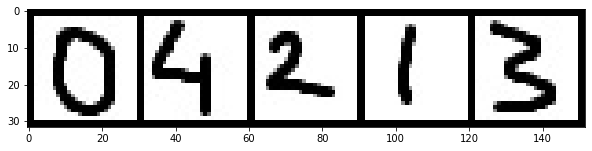

In [ ]:
# Visualize Test Images
plot = torchvision.utils.make_grid(test_images, nrow=5)
plt.figure(figsize = (10,8))
plt.imshow(plot.permute(1, 2, 0))

In [ ]:
# Make predictions
preds = model(test_images).argmax(dim=-1)
print('Predictions', preds.tolist())

Predictions [0, 4, 2, 1, 3]
